# Apple2 Floppy Drive - Reading a floppy
Notes:
* On AppleInfinitum, many say that emulating the LSS is not needed. Takes much resource and doesn't improve emulation

In [1]:
from bitstream import BitStream
from bitarray import bitarray
import matplotlib.pyplot as plt
import random
import wozardry

ModuleNotFoundError: No module named 'bitstream'

## Frequencies, speeds, etc.

CPU frequency and floppy frequency (or rotation speed)

In [2]:
FREQ_6502 = 1020484.32 # Sather, table 3.1, composite frequency (I let the long cycle go)
FLOPPY_ROUNDS_PER_SEC = 300/60  # 5 hertz, 0.2 seconds per rotation

## Floppy's stream
The floppy content is represented as a bit stream.

Sather 9-9 : 
> "When writing is not enabled, passing a field
reversal on the surface of the disk over the read/write
head induces a voltage in the coil. This induced voltage
will alternate in polarity for every field reversal.
The induced voltage is sensed by a special
purpose chip which is designed for this function.

### Read pulses

Two things here :

* Sather 9-9 : "The MC3470 detects positive and negative voltage peaks
  on the read pick-up signal, then waits about two
  microseconds to verify that a second opposite polarity
  peak has not occurred.". 
  
* However (same page): "The two microsecond delay period between peak
  detection and read pulse output turned out to be too
  short for the new format when Apple came out with
  DOS 3.3. Apple solved this problem by replacing
  fixed resistor R21 with a potentiometer on the
  analog card in the disk drive. Technicians align the
  potentiometer for an optimum delay, which works
  out to be approximately three microseconds." 

So we define the MC3470 resolution: (**FIXME** Is this measure in microseconds or in CPU cycles (so a bit faster) ? This affects the computation of the duration netween two read pulses...)

I checked several values. If it's less than 3.5 microsecs, (7 LSS cycles), then the LSS can't make sense of the data. **FIXME** **WHY** ? A clue  in Sather 9-11 :
"The write interval in the Apple is four MPU cycles, and
we will see that in the DOS formats the maximum
time between field reversals on a disk will be three
write intervals."
    
Some tests I've run:

* 5 not ok
* 4.5 not ok (D5, AA, then goes wrong)
* 4.4 NOK MusicalLand
* 4.3 OK MusicalLand
* 4.2 OK Conan, MusicalLand
* 4.1 OK Conan
* 4 cycles are OK
* 3.9 OK Conan
* 3.8 OK Conan
* 3.7 OK Conan, MusicalLand
* 3.6 OK Conan, NOK MusicalLand
* 3.5 not OK (works here but not on Conan)
* 3 Fail 


In [3]:
MC3470_DELAY = 4 # microseconds

Now we compute the maximum number of read pulses that can be emitted during one disk rotation

In [4]:
PULSES_PER_ROTATION = FREQ_6502 * (1/FLOPPY_ROUNDS_PER_SEC) / MC3470_DELAY
print(f"{PULSES_PER_ROTATION:.1f} pulses per rotation, about {PULSES_PER_ROTATION/8:.1f} bytes per rotation.")

51024.2 pulses per rotation, about 6378.0 bytes per rotation.


In [4]:
INTER_PULSE_DURATION = (1/FLOPPY_ROUNDS_PER_SEC)/PULSES_PER_ROTATION
print(f"A (0 or 1) read pulse every {1_000_000 * INTER_PULSE_DURATION:.1f} microsecond.")

A (0 or 1) read pulse every 4.0 microsecond.


### Implementation
Once a read pulse has been sensed, it will be available
to the Logical State Sequencer for one microsecond :
        
> The special purpose chip, a Motorola MC3470, outputs
a positive one microsecond pulse for every field
reversal (see Figure 9.6). This read pulse is routed
from the enabled drive to the controller."

That is implemented with the field `_read_pulse_active`.

In [5]:


class FloppyStream:
    def __init__(self, data: BitStream, one_us_in_ticks):
        self._stream = data
        
        # Number of calls to tick() method that amounts to a one microsecond
        # duration.
        
        # WARNING This computation must be exact, so one_ms_in_ticks
        # must really represent one micro second (and the only solution
        # is to have it based on an integer multiple of the base frequency)
        assert abs(one_us_in_ticks - int(one_us_in_ticks)) < 1e-16
        self._one_us_in_ticks = one_us_in_ticks
        
        # The delay between two active read pulse (at most MC3470_DELAY)
        # Since we count in ticks, we have to convert : 
        # delay = MC3470_DELAY * self._one_us_in_ticks
        self._delay = 0
        
        # Tell if a read pulse is currently available
        # for the LSS (if > 0). This will last for one
        # microsecond.
        self._read_pulse_active = 0
        
        # If read pulse is active, then this is the
        # actual value of the read pulse (0 or 1)
        self._current_read_pulse = 0
        
        
    def tick(self):
        # This is before the delay management
        # to make sure the reset of _read_pulse_active
        # is correct.
        
        if self._read_pulse_active > 0:
            self._read_pulse_active -= 1
            if self._read_pulse_active == 0:
                self._current_read_pulse = 0
                print("pulse deactivated")
                    
        r = None
        if self._delay <= 0:
            if self._stream.read(bool):
                self._current_read_pulse = 1
            else:
                self._current_read_pulse = 0  
            r = self._current_read_pulse
            # The special purpose chip, a Motorola MC3470, outputs
            # a positive one microsecond pulse for every field
            # reversal (see Figure 9.6). This read pulse is routed
            # from the enabled drive to the controller."
    
            #print(f"{self._one_us_in_ticks}")
            self._read_pulse_active = self._one_us_in_ticks
            self._delay = MC3470_DELAY * self._one_us_in_ticks
        else:
            self._delay -= 1
            
        return r
            
    def lss_read_pulse(self):
        # The LSS reads the pulse whic consumes the pulse, see Sather 9-29:
        #   "The read pulse will last for one sequencer clock because
        #    it is synchronized to the clock by a pair of flip-flops
        #    and a NAND gate."
        r = self._current_read_pulse
        self._read_pulse_active = 0
        self._current_read_pulse = 0
        return r
        
    def bits_left(self):
        return len(self._stream)       

## Logic State Sequencer

The LSS is a state machine which decodes the read pulses into nibbles.  Each time the state changes, a corresponding command is executed.

### Logic State Sequencer ROM dump
Copied from SHAMUS emulator (Sather explains how to dump it)

In [2]:
SEQ_ROM = [
    0x18, 0x18, 0x18, 0x18, 0x0A, 0x0A, 0x0A, 0x0A, 0x18, 0x18, 0x18, 0x18, 0x18, 0x18, 0x18, 0x18,
	0x2D, 0x38, 0x2D, 0x38, 0x0A, 0x0A, 0x0A, 0x0A, 0x28, 0x28, 0x28, 0x28, 0x28, 0x28, 0x28, 0x28,
	0x38, 0x28, 0xD8, 0x08, 0x0A, 0x0A, 0x0A, 0x0A, 0x39, 0x39, 0x39, 0x39, 0x3B, 0x3B, 0x3B, 0x3B,
	0x48, 0x48, 0xD8, 0x48, 0x0A, 0x0A, 0x0A, 0x0A, 0x48, 0x48, 0x48, 0x48, 0x48, 0x48, 0x48, 0x48,
	0x58, 0x58, 0xD8, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0x58, 0x58, 0x58, 0x58, 0x58, 0x58, 0x58, 0x58,
	0x68, 0x68, 0xD8, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0x68, 0x68, 0x68, 0x68, 0x68, 0x68, 0x68, 0x68,
	0x78, 0x78, 0xD8, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0x78, 0x78, 0x78, 0x78, 0x78, 0x78, 0x78, 0x78,
	0x88, 0x88, 0xD8, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0x08, 0x88, 0x08, 0x88, 0x08, 0x88, 0x08, 0x88,
	0x98, 0x98, 0xD8, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0x98, 0x98, 0x98, 0x98, 0x98, 0x98, 0x98, 0x98,
	0x29, 0xA8, 0xD8, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0xA8, 0xA8, 0xA8, 0xA8, 0xA8, 0xA8, 0xA8, 0xA8,
	0xBD, 0xB8, 0xCD, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0xB9, 0xB9, 0xB9, 0xB9, 0xBB, 0xBB, 0xBB, 0xBB,
	0x59, 0xC8, 0xD9, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0xC8, 0xC8, 0xC8, 0xC8, 0xC8, 0xC8, 0xC8, 0xC8,
	0xD9, 0xA0, 0xD9, 0xD8, 0x0A, 0x0A, 0x0A, 0x0A, 0xD8, 0xD8, 0xD8, 0xD8, 0xD8, 0xD8, 0xD8, 0xD8,
	0x08, 0xE8, 0xD8, 0xE8, 0x0A, 0x0A, 0x0A, 0x0A, 0xE8, 0xE8, 0xE8, 0xE8, 0xE8, 0xE8, 0xE8, 0xE8,
	0xFD, 0xF8, 0xFD, 0xF8, 0x0A, 0x0A, 0x0A, 0x0A, 0xF8, 0xF8, 0xF8, 0xF8, 0xF8, 0xF8, 0xF8, 0xF8,
	0x4D, 0xE0, 0xDD, 0xE0, 0x0A, 0x0A, 0x0A, 0x0A, 0x88, 0x08, 0x88, 0x08, 0x88, 0x08, 0x88, 0x08]

### Logical State Sequencer commands

These are the 4 low bits of each SEQ_ROM entry. See Sather table 9.3:

* `0x0` `CLR` CLEAR DATA REGISTER
* `$8` `NOP` NO OPERATION
* `$9` `SLO` SHIFT ZERO LEFT INTO DATA REGISTER
* `$A` `SR` SHIFT WRITE PROTECT SIGNAL RIGHT INTO DATA REGISTER
* `$B` `LD` LOAD DATA REGISTER FROM DATA BUS
* `$D` `SL1` SHIFT ONE LEFT INTO DATA REGISTER



In [3]:
SEQ_MNEMONICS = ['CLR', None,  None, None, None, None,  None, None,
                 'NOP', 'SL0', 'SR', 'LD', None, 'SL1', None, None]

### Logical State Sequencer frequency 
Sather 9-5 : 

>"The logic state sequencer is a ROM and some flip-flops wired up to act like a little 2 MHz computer."

But when one look at figure 9.7, one sees the clock comes from Q3. Moreover on
3-3, on can read:

> "Q3 is a 2 MHz clock used only in timing generation. It is available at the peripheral slots." 

and also

> "The 2 MHz signals are similar to PHASE 0 except that only one of every 130 cycles is elongated. Their normal duration is seven PERIODS or about .489 microseconds. Their long duration is nine PERIODS or about .629 microseconds."

**FIXME** According to stivo @ AppleInfinitum, there's another valid explanation. That is, Q3 is twice as fast as PHASE0. I don't know which one to choose...


In [4]:
FREQ_LSS = 1/((129*0.489/1_000_000 + 1*0.629/1_000_000)/130) # hertz
f"About {round(FREQ_LSS)} hertz"

'About 2040496 hertz'

### Implementation
The current state is in `_state`. Each time 
the state changes, a corresponding command is activated (see `_apply_command`).

In [67]:
class Sequencer:
    def __init__(self):
        self.data_register = 0
        self._state = 2 << 4
        #self._one_us_in_ticks = one_us_in_ticks
        #self._delay = 0

    def seq_rom_value(self, state, rwSwitch, slSwitch, readPulse, qa):
        r = (state & 0xF0) | (rwSwitch << 3) | (slSwitch << 2) | (readPulse << 1) | qa
        return SEQ_ROM[r]
        
    def _next_state(self, rwSwitch, slSwitch, readPulse):  
        # Sather 9-44
        #   A1- QA, the MSB of the data register
        #   A2- SHIFT/LOAD, the $C08C,X/$C08D,X switch
        #   A3- READ/WRITE, the $C08E,X/$C08F,X switch
        #   A4- The read pulse from the disk drive
        
        qa = (self.data_register & 0x80) >> 7
        self._state = self.seq_rom_value(self._state, rwSwitch, slSwitch, readPulse, qa)
        
    def _apply_command(self):
        mnemo = SEQ_MNEMONICS[self._state & 0xF]
        if mnemo == 'SL1':
            self.data_register = (self.data_register << 1) + 1
        elif mnemo == 'SL0':
            self.data_register = (self.data_register << 1) + 0
        elif mnemo == 'CLR':
            self.data_register = 0
        elif mnemo == 'NOP':            
            pass
        else:
            raise Exception("{mnemo} not supported")
    
    def tick(self, rw_switch, sl_switch, read_pulse):
        #if self._delay > 0:
        #    self._delay -= 1
        #else:
        #    self._delay = 0.5 * self._one_us_in_ticks
        self._next_state(rw_switch, sl_switch, read_pulse)
        self._apply_command()

### Identifying the LSS ROM
I check some values of the sequencer ROM. Looks like a 3.3 ROM (see Sather figure 9-11).

In [10]:
lss = Sequencer()
print(f"${lss.seq_rom_value(state=0x90, rwSwitch=0, slSwitch=0, readPulse=1, qa=0):02X}")
print(f"${lss.seq_rom_value(state=0x90, rwSwitch=0, slSwitch=0, readPulse=0, qa=0):02X}")
print(f"${lss.seq_rom_value(state=0x90, rwSwitch=0, slSwitch=0, readPulse=1, qa=1):02X}")
print(f"${lss.seq_rom_value(state=0x90, rwSwitch=0, slSwitch=0, readPulse=0, qa=1):02X}")
print()
print(f"${lss.seq_rom_value(state=0x00, rwSwitch=0, slSwitch=0, readPulse=1, qa=0):02X}")
print(f"${lss.seq_rom_value(state=0x00, rwSwitch=0, slSwitch=0, readPulse=0, qa=0):02X}")
print(f"${lss.seq_rom_value(state=0x00, rwSwitch=0, slSwitch=0, readPulse=1, qa=1):02X}")
print(f"${lss.seq_rom_value(state=0x00, rwSwitch=0, slSwitch=0, readPulse=0, qa=1):02X}")
print()
print(f"${lss.seq_rom_value(state=0xA0, rwSwitch=0, slSwitch=0, readPulse=1, qa=0):02X}")
print(f"${lss.seq_rom_value(state=0xA0, rwSwitch=0, slSwitch=0, readPulse=0, qa=0):02X}")
print(f"${lss.seq_rom_value(state=0xA0, rwSwitch=0, slSwitch=0, readPulse=1, qa=1):02X}")
print(f"${lss.seq_rom_value(state=0xA0, rwSwitch=0, slSwitch=0, readPulse=0, qa=1):02X}")

$D8
$29
$D8
$A8

$18
$18
$18
$18

$CD
$BD
$D8
$B8


## Clock simulation

The following class is here to simulate various clock
ticks. It is based on a base frequency which has to be
as fast as the fastest frequency we want to simulate.
For example, it could be the speed at which a WOZ FLUX
chunk is recorded (about 8e6 Hz).


In [11]:
class Clocks:
    def __init__(self, base_frequency):
        self.t = 0 # Tick time
        self.tn = 0 # Tick number
        self.base_frequency = base_frequency
        self._old_floppy_tick = 0
        self._old_6502_tick = 0
        self._old_lss_tick = 0
        
        self.is_floppy_tick = False
        self.cycle6502 = 0
        
    def ticks_per_microsecond(self):
        return (1/self.base_frequency) / 1_000_000
    
    def tick(self):
        self.t += self.base_frequency
        self.tn += 1

        # The floppy will take care of its own timings
        self.is_floppy_tick = True
        
        #print(f"tick: {self._old_6502_tick} {self.t / (1/FREQ_6502):.3f} FreqLSS:{FREQ_6502}")
        t = int(self.t / (1/FREQ_6502))
        if t != self._old_6502_tick:
            self._old_6502_tick = t
            self.is_6502_tick = True
            self.cycle6502 += 1
        else:
            self.is_6502_tick = False
        
        #print(f"tick: {self._old_lss_tick} {self.t / (1/FREQ_LSS):.3f} FreqLSS:{FREQ_LSS}")
        t = int(self.t / (1/FREQ_LSS))
        if t != self._old_lss_tick:
            self._old_lss_tick = t
            self.is_lss_tick = True
        else:
            self.is_lss_tick = False        

Testing the `Clocks` class:

In [12]:
clocks = Clocks(1/16_000_000)
while not clocks.is_floppy_tick:
    clocks.tick()
    s = f"{clocks.t*1_000_000:.4f} usec"
    show = False
    if clocks.is_floppy_tick:
        s += ", Floppy tick"
        show = True
    if clocks.is_6502_tick:
        s += ", 6502 tick"        
        show = True
    if clocks.is_lss_tick:
        s += ", LSS tick"
        show = True
    if show:
        print(s)
       

0.0625 usec, Floppy tick


## I/O switches

### Read/Write

From Sather 9-13 :
> `$CO8E,X/$CO8F,X` is the controller's READ/
> WRITE soft switch. It is an addressing input to the
> sequencer and divides the sequencer into its two
> most significant parts, the READ sequence and
> the WRITE sequence. It also is inverted to become
> the WRITE REQUEST signal to the drives. Thus,
> the READ/WRITE switch configures the controller for reading or writing via sequencer addressing,
> and it configures the enabled drive for writing via
> the WRITE REQUEST’ line unless a write protected disk is installed."

In [13]:
rw_switch = 0

###  SHIFT/LOAD
From Sather 9-14 : 
> SHIFT/LOAD is a fairly inadequate label for the
> `$C08C,X/$C08D,X` soft switch, but any label would
> be. It is chosen because, during writing, `$CO8C,X`
> causes shifting of the data register on every eighth
> sequencer clock, and `$C08D,X` causes loading of the
> data register from the data bus on every eighth
> sequencer clock. In reality, the SHIFT/LOAD
> switch performs several functions which defy sum-
> marization in a short label.
>
> SHIFT/LOAD is an addressing input to the
> sequencer and it divides both the READ sequence
> and the WRITE sequence into two parts. As men-
> tioned above, it is a programmable SHIFT/LOAD
> control for the data register. When the READ/-
> WRITE switch is low, the SHIFT/LOAD function is
> changed to READ/CHECK WRITE PROTECT.
> These sequencer control functions are summarized
> in Table 9.2. The operation should become clearer
> when we study the sequencer listings.

In [14]:
sl_switch = 0

## Syncing Leaders

Sather 9-24 : 
> "RWTS writes read syncing leaders by
> storing $FF to the data register in 36 cycle loops in
> DOS 3.2 and 40 cycle loops in DOS 3.3.* This creates
> a series of 111111110 or 1111111100 strings which,
> we will see, syncs up the sequencer for reading following data."

Sather 9-27 : 
> "We will see that the READ sequence will properly
> read streams of data written from the 3.2 and 3.3
> write tables in 32 cycle loops. It does take an indefinite period of time for the sequencer to sync up when
> it first encounters a random stream of data. However, random data streams in the DOS format are
> always preceded by read syncing leaders which
> force the READ sequence into syne very quickly.
> These leaders consist of a series of 111111110 or
> 1111111100 data streams. They are written by storing \$FF in the data register in 36 cycle loops
> (111111110) or 40 cycle loops (1111111100) before
> flowing directly into the 32 cycle data writing loops."

I understand that storing $FF in the data register in a 40 cycle loops means :
* The CPU puts \$FF on the data register
* The LSS shifts and stores data on the floppy at a rate of 4 CPU cycles per bits.
  So after 32 cycles, 8 ones have been written and the data register has been
  shifted 8 times so its value is zero.
* The CPU then waits an additional 8 cycles. During that time, the LSS continues
  to shift zeroes in the data register and, in 8 cycles, writes 2 zeros bits on the
  floppy.
So in the end a sequence of 8 ones followed by 2 zeros has been written on the floppy.

In [15]:
SYNC_LEAD = 0b1111111100 # 10 bits

## Running the simulation

In [16]:
# Initialize everything for a test

clocks = Clocks(1/10_000_000)

# Set soft switches
rw_switch = 0
sl_switch = 0

# Load the floppy with some test data
SYNC = (SYNC_LEAD << 12) + SYNC_LEAD # FIXME Why these values ?
nibbles = [(SYNC >> 16) & 0xFF,
           (SYNC >> 8) & 0xFF,
           (SYNC >> 0) & 0xFF,
           (SYNC >> 16) & 0xFF,
           (SYNC >> 8) & 0xFF,
           (SYNC >> 0) & 0xFF,           
           0xD5,0xAA,0x96,0xAA,0xAA]

floppy_stream = FloppyStream(BitStream(bytes(nibbles)), 
                             clocks.ticks_per_microsecond())

sequencer = Sequencer()

s = str(floppy_stream._stream)
stream_str = ""
for i in range(0,len(s),8):
    stream_str += s[i:i+8] + "_"
stream_ndx = 0

cpu_reads = 0
cpu_pause = False
while floppy_stream.bits_left() > 0:
    
    clocks.tick()
    
    tick_ms = f"{clocks.tn * clocks.base_frequency * 1_000_000: 7.2f}μs"
    
    if clocks.is_floppy_tick:
        r = floppy_stream.tick()
        if r is not None:
            # Disk reader has a new good read pulse available
            print(f"t={tick_ms}: FLOPPY {floppy_stream._current_read_pulse}")           
        
        # Display what's going on
        #stream_ndx += 1
        #if stream_str[stream_ndx] == '_':
        #    stream_ndx += 1
        #print(f"t={tick_ms}: FLOPPY {floppy_stream._read_pulse_active}| {floppy_stream._current_read_pulse} <- {stream_str[stream_ndx:]}")
    
    if clocks.is_lss_tick: 
        old_ss = sequencer._state
        rp = floppy_stream.lss_read_pulse()
        
        # rw_switch,sl_switch are constant in the simulation
        # and tells the LSS to perform read operations.
        sequencer.tick(rw_switch,sl_switch,rp)
        
        mnemo = SEQ_MNEMONICS[sequencer._state & 0xF]
        print(f"t={tick_ms}: LSS    ReadPulse:{rp} State:${old_ss:02X} -> ${sequencer._state:02X} {mnemo} | Data reg.=${sequencer.data_register:02X}")
        
    if clocks.is_6502_tick:
        # Simulate the fact the the RWTS will wait
        # for another valid data_register once it has
        # got a valid one.
        
        data_register = sequencer.data_register
        
        if cpu_pause == False and data_register & 0x80 != 0:
            cpu_reads += 1
            cpu_pause = True
            print(f"t={tick_ms}: CPU    {cpu_reads} ${data_register:02X} " + '-'*60)
        else: 
            # Pause until the data register MSB is cleared
            cpu_pause = data_register & 0x80 != 0

t=   0.10μs: FLOPPY 0
t=   0.50μs: LSS    ReadPulse:0 State:$20 -> $38 NOP | Data reg.=$00
t=   1.00μs: LSS    ReadPulse:0 State:$38 -> $48 NOP | Data reg.=$00
t=   1.50μs: LSS    ReadPulse:0 State:$48 -> $58 NOP | Data reg.=$00
t=   2.00μs: LSS    ReadPulse:0 State:$58 -> $68 NOP | Data reg.=$00
t=   2.50μs: LSS    ReadPulse:0 State:$68 -> $78 NOP | Data reg.=$00
t=   3.00μs: LSS    ReadPulse:0 State:$78 -> $88 NOP | Data reg.=$00
t=   3.50μs: LSS    ReadPulse:0 State:$88 -> $98 NOP | Data reg.=$00
t=   4.00μs: LSS    ReadPulse:0 State:$98 -> $29 SL0 | Data reg.=$00
t=   4.20μs: FLOPPY 0
t=   4.50μs: LSS    ReadPulse:0 State:$29 -> $38 NOP | Data reg.=$00
t=   5.00μs: LSS    ReadPulse:0 State:$38 -> $48 NOP | Data reg.=$00
t=   5.40μs: LSS    ReadPulse:0 State:$48 -> $58 NOP | Data reg.=$00
t=   5.90μs: LSS    ReadPulse:0 State:$58 -> $68 NOP | Data reg.=$00
t=   6.40μs: LSS    ReadPulse:0 State:$68 -> $78 NOP | Data reg.=$00
t=   6.90μs: LSS    ReadPulse:0 State:$78 -> $88 NOP | Data

t= 284.30μs: LSS    ReadPulse:0 State:$08 -> $18 NOP | Data reg.=$12
t= 284.80μs: LSS    ReadPulse:0 State:$18 -> $2D SL1 | Data reg.=$25
t= 285.30μs: LSS    ReadPulse:0 State:$2D -> $38 NOP | Data reg.=$25
t= 285.80μs: LSS    ReadPulse:0 State:$38 -> $48 NOP | Data reg.=$25
t= 286.30μs: LSS    ReadPulse:0 State:$48 -> $58 NOP | Data reg.=$25
t= 286.70μs: LSS    ReadPulse:0 State:$58 -> $68 NOP | Data reg.=$25
t= 287.10μs: FLOPPY 1
t= 287.20μs: LSS    ReadPulse:1 State:$68 -> $D8 NOP | Data reg.=$25
t= 287.70μs: LSS    ReadPulse:0 State:$D8 -> $08 NOP | Data reg.=$25
t= 288.20μs: LSS    ReadPulse:0 State:$08 -> $18 NOP | Data reg.=$25
t= 288.70μs: LSS    ReadPulse:0 State:$18 -> $2D SL1 | Data reg.=$4B
t= 289.20μs: LSS    ReadPulse:0 State:$2D -> $38 NOP | Data reg.=$4B
t= 289.70μs: LSS    ReadPulse:0 State:$38 -> $48 NOP | Data reg.=$4B
t= 290.20μs: LSS    ReadPulse:0 State:$48 -> $58 NOP | Data reg.=$4B
t= 290.70μs: LSS    ReadPulse:0 State:$58 -> $68 NOP | Data reg.=$4B
t= 291.20μs:

### Checking Sather's explanation
Here we reproduce the example of Sather 9-29

In [17]:
def dbg_lss(sequencer, rp):
    old_s = sequencer._state
    sequencer.tick(rwSwitch=0, slSwitch=0, read_pulse=rp)
    print(f"LSS    ReadPulse:{rp} ${old_s:02X} -> ${sequencer._state:02X} {SEQ_MNEMONICS[sequencer._state & 0xF]} | Data reg.=${sequencer.data_register:02X}")
    
sequencer = Sequencer()
print("You’ve got to start somewhere, and we are starting at State 2 of column 2 in the READ sequence listing of Figure 9.11. At this location in the sequencer there is a 38-NOP.")
dbg_lss(sequencer, 0)
print("""At State 3, there is a 48-NOP""")
dbg_lss(sequencer, 0)
print("""At State 4, there is a 58-NOP. We are sequencing through the states,
waiting for a read pulse. """)

dbg_lss(sequencer, 0)
dbg_lss(sequencer, 0)
print("""Assume a read pulse occurs at State 6, switching the sequencer to column 1.""")

dbg_lss(sequencer, 1) # at state 6
print("""The
read pulse will last for one sequencer clock because
it is synchronized to the clock by a pair of flip-flops
and a NAND gate. There is a D8-NOP at State 6 in
column 1. In fact if you look at column 1, a read pulse
at any of the states would have resulted in a
D8-NOP.

When the read pulse goes away after the next
clock, the sequencer goes to State D in column 2, a
08-NOP.""")
dbg_lss(sequencer, 0)
dbg_lss(sequencer, 0)
print("""This means move down to State 0(18-NOP)
and then up to State 1 (2D-SL1). This SHIFT LEFT
ONE is a direct consequence of the read pulse. A
read pulse occurred, so a ONE was shifted in.""")
dbg_lss(sequencer, 0)
print("""Assume the SL1 does not cause QA to become set,
and don’t get tired of assumptions. We now sequence
to State 2 in column 2, right where we started, mov-
ing down the line, waiting for a read pulse.""")
dbg_lss(sequencer, 0)
print("""This time let’s say no read pulse occurs before we
reach State 9. This is the point at which the
sequencer decides it can’t wait for a ONE any
more—that was a ZERO bit. State 9 is a 29-SL0. A
ZERO is shifted in.""")
dbg_lss(sequencer, 0)
dbg_lss(sequencer, 0)
dbg_lss(sequencer, 0)
dbg_lss(sequencer, 0)
dbg_lss(sequencer, 0)
dbg_lss(sequencer, 0) # wait until state 9
dbg_lss(sequencer, 0)
print("""We'll say QA is still not set and
we're back to State 2, waiting for a read pulse.""")
dbg_lss(sequencer, 0)
print("""This
eycle will continue until QA becomes set after an
SLO or SL1. The sequencer is shifting in data based
on the presence or absence of read pulses.""")

You’ve got to start somewhere, and we are starting at State 2 of column 2 in the READ sequence listing of Figure 9.11. At this location in the sequencer there is a 38-NOP.
LSS    ReadPulse:0 $20 -> $38 NOP | Data reg.=$00
At State 3, there is a 48-NOP
LSS    ReadPulse:0 $38 -> $48 NOP | Data reg.=$00
At State 4, there is a 58-NOP. We are sequencing through the states,
waiting for a read pulse. 
LSS    ReadPulse:0 $48 -> $58 NOP | Data reg.=$00
LSS    ReadPulse:0 $58 -> $68 NOP | Data reg.=$00
Assume a read pulse occurs at State 6, switching the sequencer to column 1.
LSS    ReadPulse:1 $68 -> $D8 NOP | Data reg.=$00
The
read pulse will last for one sequencer clock because
it is synchronized to the clock by a pair of flip-flops
and a NAND gate. There is a D8-NOP at State 6 in
column 1. In fact if you look at column 1, a read pulse
at any of the states would have resulted in a
D8-NOP.

When the read pulse goes away after the next
clock, the sequencer goes to State D in column 2, a
08-NOP

### RWTS
Here I check the number of cycles it takes for some operations from the RWTS.

#### Extract from RWTS routine (reading D5/AA)
```
rda1:
   (4 cycles)   lda q6l,x                           ;read nibl.
   (2-3 cycles) bpl rda1                            ;*** no page cross! ***
rdasn1:
   (2 cycles)   cmp #$d5                            ;adr mark 1?
   (2-3 cycles) bne rdasyn                          ;(loop if not)

   (2 cycles)   nop                                 ;added nibl delay.

rda2:
   lda          q6l,x
```

# Converting a DSK to a bit stream

### Nibblize a sector

Normal byte (lower six bits only) -> disk byte translation table:

In [18]:
BYTE_TRANSLATION = [
    0x96, 0x97, 0x9a, 0x9b, 0x9d, 0x9e, 0x9f, 0xa6,
    0xa7, 0xab, 0xac, 0xad, 0xae, 0xaf, 0xb2, 0xb3,
    0xb4, 0xb5, 0xb6, 0xb7, 0xb9, 0xba, 0xbb, 0xbc,
    0xbd, 0xbe, 0xbf, 0xcb, 0xcd, 0xce, 0xcf, 0xd3,
    0xd6, 0xd7, 0xd9, 0xda, 0xdb, 0xdc, 0xdd, 0xde,
    0xdf, 0xe5, 0xe6, 0xe7, 0xe9, 0xea, 0xeb, 0xec,
    0xed, 0xee, 0xef, 0xf2, 0xf3, 0xf4, 0xf5, 0xf6,
    0xf7, 0xf9, 0xfa, 0xfb, 0xfc, 0xfd, 0xfe, 0xff]

How to turn bytes into nibbles (which in turn represent the actual bit stream on the floppy)

In [19]:
def bits_to_bools(number):
    # FIXME make sure the MSBit is 1 !!!
    return [x == '1' for x in f"{number:b}"]    

In [20]:
SECTOR_SIZE = 256

def nibblize_sector(vol, trk, sector, bytez: bytes):
    # This was copied from rustyapple emulator source
    
    assert len(bytez) == SECTOR_SIZE, f"{len(bytez)} instead of {SECTOR_SIZE} ?!"
    
    # Write the address block.  Use 4-and-4 encoding to convert
    # the volume, track and sector and checksum into 2 disk bytes each.
    # The checksum is a simple exclusive OR of the first three values.
    
    # Note that 0xAA = 0b10101010
    
    chksum = vol^trk^sector;
    address_block = [
         ((vol >> 1) | 0xaa), (vol | 0xaa),
         ((trk >> 1) | 0xaa), (trk | 0xaa),
         ((sector >> 1) | 0xaa), (sector | 0xaa),
         ((chksum >> 1) | 0xaa), (chksum | 0xaa)]

    # Read the next 256-byte sector from the old disk image file,
    # and add two zero bytes to bring the number of bytes up to a multiple
    # of 3. (256+2 == 258 / 3 = 86)
       
    sector_buffer = list(bytez) + [0,0]
      
    # Write the first 86 disk bytes of the data block, which
    # encodes the bottom two bits of each sector byte into six-bit
    # values as follows:
    #
    # disk byte n, bit 0 = sector byte n,       bit 1
    # disk byte n, bit 1 = sector byte n,       bit 0
    # disk byte n, bit 2 = sector byte n +  86, bit 1
    # disk byte n, bit 3 = sector byte n +  86, bit 0
    # disk byte n, bit 4 = sector byte n + 172, bit 1
    # disk byte n, bit 5 = sector byte n + 172, bit 0
    #
    # The scheme allows each pair of bits to be shifted to the right out
    # of the disk byte, then shifted to the left into the sector byte.
    #
    # Before the 6-bit value is translated to a disk byte, it is exclusive
    # ORed with the previous 6-bit value, hence the values written are
    # really a running checksum.
    
    prev_value = 0
    value = 0
    data_block_1 = [0]*86
    for i in range(86): # 86*3 = 258
        value  = (sector_buffer[i] & 0x01) << 1
        value |= (sector_buffer[i] & 0x02) >> 1
        value |= (sector_buffer[i + 86] & 0x01) << 3
        value |= (sector_buffer[i + 86] & 0x02) << 1
        value |= (sector_buffer[i + 172] & 0x01) << 5
        value |= (sector_buffer[i + 172] & 0x02) << 3
        data_block_1[i] = BYTE_TRANSLATION[(value ^ prev_value)]
        prev_value = value;

    # Write the last 256 disk bytes of the data block, which
    # encodes the top six bits of each sector byte.  Again, each value
    # is exclusive ORed with the previous value to create a running
    # checksum (the first value is exclusive ORed with the last value of
    # the previous step).

    data_block_2 = [0] * SECTOR_SIZE
    for i in range(SECTOR_SIZE):
        value = (sector_buffer[i] >> 2)
        data_block_2[i] = BYTE_TRANSLATION[(value ^ prev_value)]
        prev_value = value

    checksum = BYTE_TRANSLATION[value]

    # Finally, build the bitstream
    bs = BitStream()
    
    # Sync
    
    # Sather 9-27 : "RWTS 3.3 uses FFs written in 40 cycle loops as read
    # syncing leaders. A string of four FF'40s followed by
    # valid data will ensure that following data will be in
    # sync."
    
    # In rustyapple it's 14*$FF == 14*8 == 112 bits
    # SYNC_LEAD is ten bits.
    
    bs.write(bits_to_bools(SYNC_LEAD)*8,type=bool)
    
    # Header
    bs.write(bytes([0xD5, 0xAA, 0x96]))
    bs.write(bytes(address_block))
    bs.write(bytes([0xDE, 0xAA, 0xEB]))
    
    # Sync (6*$FF == 48 bits by rustyapple)
    bs.write(bits_to_bools(SYNC_LEAD)*4,type=bool)
    
    # Body
    bs.write(bytes([0xD5, 0xAA, 0xAD]))
    bs.write(bytes(data_block_1))
    bs.write(bytes(data_block_2))
    
    bs.write(bytes([checksum]))
    
    bs.write(bytes([0xDE, 0xAA, 0xEB]))    
    
    # Returning the concatenation of data blocks for 
    # analysis purpose
    return bs, data_block_1 + data_block_2 + [checksum]

### Read one sector from the floppy
Now we can nibblize a sector, we make a full test : nibblize a sector
and then read the resulting bit stream with the LSS.

In [21]:
#bytez = list(range(16))*16
#bytez = [0,1]*128
# sector_stream, org_data = nibblize_sector(vol=0, trk=1, sector=2, bytez=bytez)
# asbool = sector_stream.read(bool,n=len(sector_stream))
# sector_stream = BitStream( asbool + asbool, bool)

with open("conan.dsk","rb") as fin:
    bytez = fin.read(SECTOR_SIZE)
    sector_stream, org_data = nibblize_sector(vol=254, trk=0, sector=0, bytez=bytez)
    bytez = fin.read(SECTOR_SIZE)
    sector_stream2, org_data = nibblize_sector(vol=254, trk=0, sector=1, bytez=bytez)
    sector_stream.write(sector_stream2)

print(",".join([f"{x:02X}" for x in org_data]))
print(f"Nibblized data are {len(sector_stream)} bits = {len(sector_stream)/8:.2f} bytes long")
print(f"{len(sector_stream)} bits for one sector, so {len(sector_stream)*16} bits for a track, out of {int(PULSES_PER_ROTATION)} available")

E5,DB,9D,CB,B5,B6,BC,F2,F4,9B,9F,AB,B3,D9,DF,FB,EE,9F,9E,9E,B2,96,DE,E9,EB,AF,9B,BB,BA,D9,E7,E5,EF,CB,AB,9A,AB,BE,B5,B9,9D,EF,EA,EC,B2,D7,FF,BD,97,FD,F7,AE,ED,E7,AF,E6,FE,FE,FF,B5,EE,EC,DF,FC,CF,FD,AF,AE,EF,EB,DB,96,EB,D3,DA,B7,DA,DA,96,AC,D9,CD,F9,9F,AC,9B,E5,DF,DA,D3,B5,9E,DF,DA,BD,BB,B2,CF,B4,D3,B5,BD,BB,AE,F2,EE,BE,BC,9E,B6,B4,A6,DC,DC,96,BB,96,BB,BB,A6,B5,9E,DF,D7,F2,FA,B6,B4,A6,DC,DC,96,FE,B7,96,B7,B7,DF,BA,B4,A6,EB,DE,BD,BB,A6,A6,9E,B6,EF,DC,96,9A,AF,B6,BF,E6,DA,CF,B4,9E,BC,CD,AB,A6,BB,B5,A6,A6,E6,D7,EB,EB,EB,EB,F2,FA,E5,ED,FE,FB,F4,ED,FE,F2,ED,DA,AE,B7,AC,FE,FA,A7,D3,9D,BE,B2,BD,DD,F7,B9,E6,EA,AE,B7,B5,E6,B3,FA,CD,BB,AB,F4,DA,9F,9F,97,A6,BE,F4,D9,AB,A6,B5,AF,9A,BE,A6,BE,F6,F2,F5,EF,BF,96,9D,9E,A7,DE,96,E6,97,F7,D7,CE,96,AF,B6,DA,B7,DF,9B,9D,97,9B,BD,F4,96,EC,AE,B7,AC,FE,FA,DD,EC,EC,BF,CD,BB,A7,EC,9B,E9,AC,AE,CF,B6,9D,BB,F2,9D,9A,B2,D3,B5,A6,E6,DA,D3,B5,9F,BA,B7,FF,EA,CD,BE,BC,F4,EF,E6,E6,B2,F3,D9,9F,AC,DD,BD,9F,A6,9B,9D,FC,BC,EA,EA,EA,BD,BD,FF,FF,9B,FD,B7,EA,EA,EA,96,96,96,FF,D

In [22]:
# Initialize everything for a test

clocks = Clocks(1/10_000_000)
sequencer = Sequencer()
floppy_stream = FloppyStream(sector_stream, 
                             clocks.ticks_per_microsecond())

cpu_pause = False
read_data = []
while floppy_stream.bits_left() > 0:
    
    clocks.tick()
    
    if clocks.is_floppy_tick:
        floppy_stream.tick()

    if clocks.is_lss_tick: 
        sequencer.tick(rw_switch,sl_switch,floppy_stream.lss_read_pulse())
        
    if clocks.is_6502_tick:
        # Simulate the fact the the RWTS will wait
        # for another valid data_register once it has
        # got a valid one.
        
        data_register = sequencer.data_register
        
        if (data_register & 0x80 != 0) and not cpu_pause:
            cpu_pause = True
            read_data.append(f"_{ data_register:02X}")
        elif data_register & 0x80 == 0: 
            cpu_pause = False
            #read_data.append(f"{data_register:02X}")

print(" ".join(read_data))    


_FF _FF _FF _FF _FF _FF _FF _FF _D5 _AA _96 _FF _FE _AA _AA _AA _AA _FF _FE _DE _AA _EB _FF _FF _FF _FF _D5 _AA _AD _9A _9D _9E _9E _9D _9F _A7 _B2 _B5 _EF _B4 _D6 _96 _9B _9A _9A _97 _EE _E6 _E6 _DA _AB _D9 _E7 _AF _AC _FD _DE _B6 _B3 _F4 _BA _BB _F6 _A7 _AC _DF _BD _FA _D9 _CD _FF _AC _DA _D9 _F2 _D7 _B6 _EE _D9 _ED _B5 _EE _D9 _B7 _D7 _EE _B5 _ED _EE _EE _96 _D7 _96 _9A _DA _97 _F2 _B6 _97 _9B _96 _B6 _B6 _F2 _B4 _96 _B4 _B6 _97 _97 _97 _B5 _EE _D7 _9B _97 _E5 _D6 _FB _ED _F5 _EF _EC _DA _BD _96 _96 _96 _B4 _EF _B5 _EB _DC _FD _F5 _EB _AB _EA _B9 _FD _BE _DB _FD _D7 _CD _FD _E5 _B9 _FD _B2 _AB _E6 _FC _B5 _DA _EB _FC _AE _FD _E5 _B9 _FD _DA _DF _FA _AE _FD _E7 _DA _B5 _B9 _B3 _FB _9D _FD _F9 _9D _FD _AC _E6 _CE _F6 _E9 _CB _F6 _9B _F4 _BC _DA _BE _FE _EC _9A _9B _97 _96 _9B _96 _97 _96 _9B _96 _97 _96 _9B _96 _97 _9B _9B _96 _96 _96 _96 _96 _96 _96 _96 _96 _96 _ED _BD _9E _BA _9B _B7 _B4 _9D _9D _96 _9A _B6 _9B _9B _9D _96 _96 _97 _9F _A6 _97 _9F _A6 _96 _E9 _96 _96 _96 _96 _96 _96 

### Nibblize a disk

We assume a regular disk (no copy protection tricks)

In [23]:
TRACK_SIZE = SECTOR_SIZE * 16
TRACKS_PER_FLOPPY = 35
SKEWING_TABLE = [0,7,14,6,13,5,12,4,11,3,10,2,9,1,8,15]

We nibblize a disk track by track. Pay attention to the fact that the DSK sectors are reordered...

In [24]:
def nibblize_track(volume, track, track_bytes):
    track_bs = BitStream()
    for sector in range(16):
        rs = SKEWING_TABLE[sector]
        bs, _ = nibblize_sector(volume, track, sector, track_bytes[rs*SECTOR_SIZE:(rs+1)*SECTOR_SIZE])
        track_bs.write(bs)
        
    # Tentative fix FIXME 
    bs.write(bits_to_bools(SYNC_LEAD),type=bool)
    return track_bs

Now we test this we a full disk

In [25]:
#with open("conan.dsk","rb") as fin:
with open("boulder_dash.dsk","rb") as fin:
#with open("/mnt/data2/roms/Apple/Musical_Land.dsk","rb") as fin:
    disk = fin.read()
    
tracks = []
for track in range(TRACKS_PER_FLOPPY):
    tracks.append(nibblize_track(0, track, disk[track*TRACK_SIZE:(track+1)*TRACK_SIZE]))

In [26]:
",".join([f"Track:{tn} {len(t)} bits" for tn,t in enumerate(tracks)])

'Track:0 48384 bits,Track:1 48384 bits,Track:2 48384 bits,Track:3 48384 bits,Track:4 48384 bits,Track:5 48384 bits,Track:6 48384 bits,Track:7 48384 bits,Track:8 48384 bits,Track:9 48384 bits,Track:10 48384 bits,Track:11 48384 bits,Track:12 48384 bits,Track:13 48384 bits,Track:14 48384 bits,Track:15 48384 bits,Track:16 48384 bits,Track:17 48384 bits,Track:18 48384 bits,Track:19 48384 bits,Track:20 48384 bits,Track:21 48384 bits,Track:22 48384 bits,Track:23 48384 bits,Track:24 48384 bits,Track:25 48384 bits,Track:26 48384 bits,Track:27 48384 bits,Track:28 48384 bits,Track:29 48384 bits,Track:30 48384 bits,Track:31 48384 bits,Track:32 48384 bits,Track:33 48384 bits,Track:34 48384 bits'

# Nibblize with CPU cycles
Here we nibblize a disk track by track and turn that into a bit stream. Then we "run" the logic state sequencer over the bit stream. This will produce all the values of the LSS's data register that we will measure at each CPU cycle. The goal is to know the value of the data register at any moment in the emulation. So we record the data register values at all CPU cycles during a full track read (about 200000 values (bytes) per track). 

Of course, doing so, we won't be able to emulate correctly a read head move from one track to another because we won't know at which point the LSS will resyn with the track data.

In [27]:
data_register = []
for track_ndx, track in enumerate(tracks):
    clocks = Clocks(1/10_000_000)
    sequencer = Sequencer()
    floppy_stream = FloppyStream(track, 
                                 clocks.ticks_per_microsecond())
    temp = []
    while floppy_stream.bits_left() > 0:
    
        clocks.tick()
    
        if clocks.is_floppy_tick:
            floppy_stream.tick()

        if clocks.is_lss_tick: 
            sequencer.tick(rw_switch,sl_switch,floppy_stream.lss_read_pulse())
        
        if clocks.is_6502_tick:
            temp.append( sequencer.data_register)
    
    data_register.extend(temp)
    print(f"{track_ndx+1:02d}/{len(tracks)} Track len:{len(temp)} Disk len:{len(data_register)}")
    
with open("conan.bin","wb") as fout:    
    fout.write(bytearray(data_register))    

01/35 Track len:202433 Disk len:202433
02/35 Track len:202433 Disk len:404866
03/35 Track len:202433 Disk len:607299
04/35 Track len:202433 Disk len:809732
05/35 Track len:202433 Disk len:1012165
06/35 Track len:202433 Disk len:1214598
07/35 Track len:202433 Disk len:1417031
08/35 Track len:202433 Disk len:1619464
09/35 Track len:202433 Disk len:1821897
10/35 Track len:202433 Disk len:2024330
11/35 Track len:202433 Disk len:2226763
12/35 Track len:202433 Disk len:2429196
13/35 Track len:202433 Disk len:2631629
14/35 Track len:202433 Disk len:2834062
15/35 Track len:202433 Disk len:3036495
16/35 Track len:202433 Disk len:3238928
17/35 Track len:202433 Disk len:3441361
18/35 Track len:202433 Disk len:3643794
19/35 Track len:202433 Disk len:3846227
20/35 Track len:202433 Disk len:4048660
21/35 Track len:202433 Disk len:4251093
22/35 Track len:202433 Disk len:4453526
23/35 Track len:202433 Disk len:4655959
24/35 Track len:202433 Disk len:4858392
25/35 Track len:202433 Disk len:5060825
26/3

# MC3470

In [218]:
woz_flux = [int(x) for x in "00100100000000000000000000000000000001000101000000000000000000000000000000010001010010001000010000000000000000000000000000111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001"]
woz_flux = 3*woz_flux

In [220]:
def trans_to_signal(bits):
    last_val = bits[0]
    voltage = -1
    v = [voltage]
    for i in range(1,len(bits)):
        if bits[i] == 1:
            voltage = - voltage
        v.append(voltage)
    assert len(v) == len(bits)
    return v

In [221]:

random.random()
mcd_rnd = 1
for i in range(31):
    mcd_rnd = mcd_rnd << 1
    if random.random() <= 0.05:
        mcd_rnd |= 1
f"{mcd_rnd:b}"

'10000000100000000000000000000000'

In [68]:
class MC3470Process:
    # A flux is a bit array. Each 1 represents a transition. A zero
    # represents no transition.
    # A transition is idealized as instantaneous.
    # A zero represents a 125 nanosec duration
    # Here we reproduce a bit of the MC347° fuinctionality. But pay attention !
    # The flux data in a WOZ file is the output of the MC3470
    # so this code may be a bit "too much".
    def emit_pulse(self, start_time, type_, duration):
        if len(self.signal_chunks) == 0:
            self.signal_chunks.append((start_time, type_, duration))
        else:
            last_start_time, last_type, last_duration = self.signal_chunks[-1]
            if start_time >= last_start_time + last_duration:
                self.signal_chunks.append((start_time, type_, duration))
            
        
    def __init__(self, flux):
        self.signal_chunks = []
        noise_check_count = 0
        noise_check = False
        blank_signal_duration = 0
        STEPS_FOR_ONE_MICROSEC = 8
        for i in range(len(flux)):

            # noise_check: we have seen one transition and we're
            #   checking that none occurs before 3microsec.
            if noise_check and flux[i] == 0:
                # Still no transition occured
                noise_check_count += 1 

                if noise_check_count >= 3*STEPS_FOR_ONE_MICROSEC - 1:
                    # No transition occured during the 3 microsec window
                    # => the transition was genuine; not noise
                    noise_check_count = 0
                    noise_check = False
                    self.emit_pulse(i, "PULSE", 1*STEPS_FOR_ONE_MICROSEC)

            if flux[i] == 1:
                if blank_signal_duration > 12*STEPS_FOR_ONE_MICROSEC:
                    weak_duration = blank_signal_duration - 12*STEPS_FOR_ONE_MICROSEC
                    self.emit_pulse(i-weak_duration, "WEAK", weak_duration-1)

                noise_check = True
                noise_check_count = 0
                blank_signal_duration = 0

            elif flux[i] == 0:
                blank_signal_duration += 1


def plot_mc3470(flux, mc, xlim, title):
    # clip
    for i in range(len(mc.signal_chunks)):
        start_time, type_, duration = mc.signal_chunks[i+1]
        if start_time > xlim[0]:
            break
    j = i
    while True:
        start_time, type_, duration = mc.signal_chunks[j]
        if start_time + duration < xlim[1]:
            j += 1
        else:
            break
            
    start_chunk=i
    end_chunk=j+1
    start = mc.signal_chunks[start_chunk][0]
    end = mc.signal_chunks[end_chunk][0]
            
    f, ax = plt.subplots(1, 1, figsize = (20, 5))
    ax.set_xlim([start,end])
    ax.step(range(start,end), trans_to_signal(flux[start:end]), where="pre", label="WOZ flux", linewidth=0.5, color="black", antialiased=None)
    if (end-start)/8 < 20:
        tick_div = 1
    else:
        tick_div = round((end-start)/8 + 0.5)
    ticks = range(start,end,tick_div)
    ax.set_xticks(ticks)
    #ax.set_xlim([len(flux)/3, 2/3*len(woz_flux)])
    ax.set_xticklabels([f"{round(t*0.125)}" for t in ticks])
    ax.set_xlabel("Time (μs)")
    label_weak, label_pulse = "Weak bits", "Read Pulse"
    last_end = 0
    
    for chunk in mc.signal_chunks[start_chunk:end_chunk+1]:
        start_time, type_, duration = chunk
        ax.hlines(y=0,xmin=last_end,xmax=start_time,color="red")
        last_end = start_time+duration
        if type_ == "PULSE":
            ax.plot([start_time,start_time, start_time+duration, start_time+duration],
                    [0, 0.25, 0.25, 0],color="red",label=label_pulse)
            label_pulse = None
        elif type_ == "WEAK":
            ax.plot([start_time,start_time, start_time+duration, start_time+duration],
                    [0, 0.125, 0.125, 0],linestyle='dashed',color="red",label=label_weak)
            label_weak = None
    ax.legend(loc='lower right')
    ax.grid(color="#ACE6D7")
    ax.set_title(f"MC3470 Simulation - {title}")
    return ax

In [3]:
def woz_to_flux(woz_image, track_number):
    bs = bitarray()
    count = 0
    for b in woz_image.tracks[woz_image.flux[0]].raw_bytes:
        if b < 255:
            count += b
            bs.extend([0]*(count-1))
            bs.append(1)
            count = 0
        else:
            count += 255
    return bs

In [69]:
READ_PULSE="RP" # A read pulse followed by no signal
WEAK_BITS="WEAK"
NO_PULSE="NO_SIG"
STABLE_READ_LENGTH=16*8 # 16*8 * 0.125 microsec = 16 microsec (see WOZ Spec)
ONE_MICROSECOND = 8

"""
DiskBLitz: Applesauce reads the output of the drive and therefore the MC3470. 
           To reconstruct the signal from the flux track, each timing value
           is the rising edge of a 1us wide pulse.
"""

class MC3470Flux:
    def __init__(self, woz_image, floppy_track_number):
        self.signal_chunks = []
        time_offset = 0
        count = 0
        raw_track = woz_image.seek(floppy_track_number)
        print(f"Dropping {len(raw_track.raw_bytes)-raw_track.raw_count} bytes")
        for ndx, b in enumerate(raw_track.raw_bytes[:raw_track.raw_count]):
            if b < 8 :
                print(f"Warning: Broken WOZ ? {b} nanosec duration in WOZ file at {ndx}/{len(raw_bytes)}")
            elif b < 255:
                count += b
                
                if count > STABLE_READ_LENGTH:
                    if woz_image.info["cleaned"]:
                        # Weak bits are there
                        self.signal_chunks.append( (time_offset, READ_PULSE, ONE_MICROSECOND) )
                        time_offset += ONE_MICROSECOND
                        self.signal_chunks.append( (time_offset, NO_PULSE, STABLE_READ_LENGTH - ONE_MICROSECOND) )
                        time_offset += STABLE_READ_LENGTH - ONE_MICROSECOND
                        self.signal_chunks.append( (time_offset, WEAK_BITS, count-(STABLE_READ_LENGTH - ONE_MICROSECOND)) )
                        time_offset += count-(STABLE_READ_LENGTH - ONE_MICROSECOND)
                        print(f"Weak bits at {ndx}")
                    else:
                        time_offset += count
                        print("Weak bits detected, but WOZ image not cleaned ! SKiping")                        
                else:
                    self.signal_chunks.append( (time_offset, READ_PULSE, ONE_MICROSECOND) )
                    time_offset += ONE_MICROSECOND
                    self.signal_chunks.append( (time_offset, NO_PULSE, count - ONE_MICROSECOND))
                    time_offset += count - ONE_MICROSECOND
             
                count = 0
            else:
                count += 255
        

In [70]:
def plot_mc3470(flux, xlim, title):
    from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
    # clip
    for i in range(len(mc.signal_chunks)):
        start_time, type_, duration = mc.signal_chunks[i+1]
        if start_time + duration > xlim[0]:
            break
    j = i
    while True:
        start_time, type_, duration = mc.signal_chunks[j]
        if start_time < xlim[1]:
            j += 1
        else:
            break
            
    start_chunk=i
    end_chunk=j
    start = mc.signal_chunks[start_chunk][0]
    end = mc.signal_chunks[end_chunk][0]
            
    f, ax = plt.subplots(1, 1, figsize = (20, 3))


    if (end-start)/8 < 40:
        tick_div = 8
    else:
        tick_div = round((end-start) / 20)
            
    #ticks = range(start,end,tick_div)
    #ax.set_xticks(ticks)
    
    #ax.set_xticklabels([f"{round(t*0.125)}" for t in ticks])
    ax.grid(which="minor", color="#ACE6D7")
    ax.grid(which="major", color="#ACE6D7")

    label_weak, label_pulse, label_no_signal = "Weak bits", "Read Pulse", "No signal"
    for chunk in mc.signal_chunks[start_chunk:end_chunk+1]:
        start_time, type_, duration = chunk
        if type_ == NO_PULSE:
            ax.plot([start_time, start_time+duration],
                    [0,0],color="gray",label=label_no_signal)
            label_no_signal = None
        elif type_ == READ_PULSE:
            ax.plot([start_time, start_time, start_time+duration, start_time+duration],
                    [0,1,1,0],color="red",label=label_pulse)
            label_pulse = None
        elif type_ == WEAK_BITS:
            ax.plot([start_time, start_time+duration],
                    [0,0],linestyle='dashed',color="red",label=label_weak)
            label_weak = None
    ax.scatter(range(0,end,4),[0.5]*len(range(0,end,4)),color="black",label="LSS read")
    ax.set_xlabel("Time (125 nanosec)")
    ax.xaxis.set_minor_locator(MultipleLocator(4))    
    ax.set_title(f"MC3470 Simulation - {title}")
    ax.tick_params(left=False, labelleft=False)
    ax.set_xlim(xlim[0],xlim[1])    
    ax.legend(loc='lower right')
    return ax

In [71]:
with open("/mnt/data2/roms/Apple/woz test images/WOZ 2.1 (with FLUX chunks)/ProDOS User's Disk - Disk 1, Side A.woz", "rb") as fp:
    woz_image = wozardry.WozDiskImage(fp)
    print(woz_image.meta['title'])

mc = MC3470Flux(woz_image, 0)

ProDOS User's Disk
Dropping 324 bytes
Weak bits at 1481


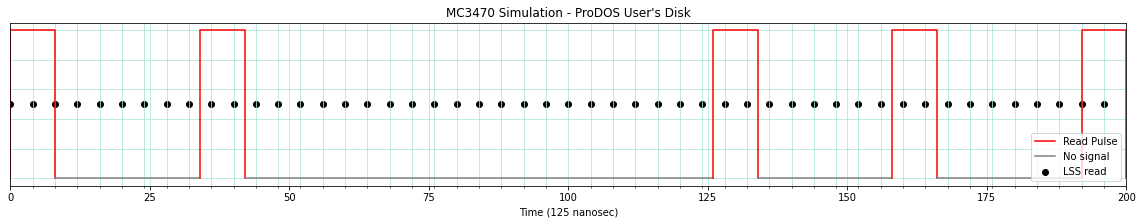

In [72]:
# See the weak bits
#offset=(71600//8)*8
#duration=400
offset=0
duration=200
plot_mc3470(mc,[offset, offset+duration], woz_image.meta['title']);

In [82]:
lss = Sequencer()
mc3470_time = 0
mc3470_chunk = 0
lss_time = 0
data_register = []
read_pulses = []

debug_chunk = True

while True:
    lss_end_time = lss_time + 4 - 1 # 4*0.125=0.5 microsec
    if lss_end_time > 200000:
        break
    
    read_pulse = 0
    start_time, type_, duration = mc.signal_chunks[mc3470_chunk]   
    chunk_end_time = start_time + duration - 1
    while True:
        
        #print(f"LSS time:{lss_time}, MC3470 time:{mc3470_time}, chunk:{mc3470_chunk}")
        #if debug_chunk:
        #    print(f"#{mc3470_chunk}: {start_time}, {type_}, {duration}")
        #    debug_chunk = False
            
        if type_ == NO_PULSE:
            pass
        elif type_ == READ_PULSE:
            read_pulse |= 1
        elif type_ == WEAK_BITS:
            read_pulse = 0
            
        mc3470_time += 1 # Can be 0.95, 1.05, the real speed...
        
        if   mc3470_time <= chunk_end_time  and mc3470_time <= lss_end_time:
            pass
        elif mc3470_time <= chunk_end_time  and mc3470_time > lss_end_time:
            break
        elif mc3470_time > chunk_end_time and mc3470_time <= lss_end_time:
            mc3470_chunk += 1
            start_time, type_, duration = mc.signal_chunks[mc3470_chunk]   
            chunk_end_time = start_time + duration - 1
            debug_chunk = True
        elif mc3470_time > chunk_end_time and mc3470_time > lss_end_time:
            mc3470_chunk += 1
            start_time, type_, duration = mc.signal_chunks[mc3470_chunk]   
            chunk_end_time = start_time + duration - 1
            debug_chunk = True
            break
            
    read_pulses.append(read_pulse)
    lss.tick(0,0,read_pulse)
    data_register.append(lss.data_register)
    lss_time += 4
    
print(f"LSS time:{lss_time}, MC3470 time:{mc3470_time}, chunk:{mc3470_chunk}")
#print(read_pulses)
#print(",".join([f"${dr:02X}" for dr in data_register]))
filtered = [0]
watch = False
for dr in data_register:
    if dr & 0x80 != 0 and not watch:
        filtered.append(dr)
        watch = True
    elif dr & 0x80 == 0:
        watch = False
print(",".join([f"${dr:02X}" for dr in filtered]))

LSS time:200000, MC3470 time:200000, chunk:9036
$00,$CE,$D7,$FB,$FB,$B2,$9F,$AB,$D9,$D7,$FA,$FB,$DF,$E6,$B6,$B5,$97,$DB,$DB,$EE,$B6,$DA,$B3,$D9,$E5,$EC,$A7,$DD,$97,$F9,$FF,$EC,$E5,$EC,$9B,$E9,$9B,$CD,$BF,$EF,$F6,$D7,$B5,$DD,$B7,$9A,$D7,$9B,$B4,$F7,$CF,$E5,$BC,$D7,$DE,$DB,$9A,$EB,$AE,$E7,$DA,$DD,$F9,$EB,$BE,$9A,$D9,$96,$9A,$CD,$9E,$9A,$96,$9B,$96,$9E,$A6,$97,$96,$CB,$9B,$9B,$BD,$9B,$96,$9A,$9B,$9B,$9D,$97,$9D,$9E,$A6,$97,$96,$CB,$BE,$9E,$96,$A6,$A6,$CD,$9A,$96,$E6,$BD,$F7,$D6,$96,$D6,$D6,$96,$96,$96,$96,$96,$96,$BF,$B6,$F2,$F2,$AD,$AD,$E5,$E5,$E7,$E7,$FD,$FD,$A7,$96,$9A,$BE,$CB,$A7,$96,$A7,$FC,$FC,$9D,$9D,$DA,$E7,$A7,$9A,$9A,$96,$96,$9E,$9E,$96,$D6,$D6,$B5,$B5,$FB,$F2,$F6,$FF,$96,$F3,$F3,$96,$96,$BB,$E5,$FF,$96,$EC,$EC,$96,$96,$B7,$B7,$96,$E9,$E9,$97,$97,$96,$DB,$DB,$A7,$A7,$AD,$AC,$97,$DB,$AD,$DF,$A6,$DB,$DB,$F3,$AB,$AF,$ED,$B5,$FA,$D7,$AC,$B5,$FA,$E7,$F3,$A7,$AE,$ED,$96,$EB,$EB,$97,$97,$B9,$BA,$97,$EB,$AD,$DC,$96,$EB,$EB,$FE,$97,$B3,$EE,$D6,$B3,$D6,$B2,$D7,$B3,$EB,$FE,$97,$B3,$B3,$FF,

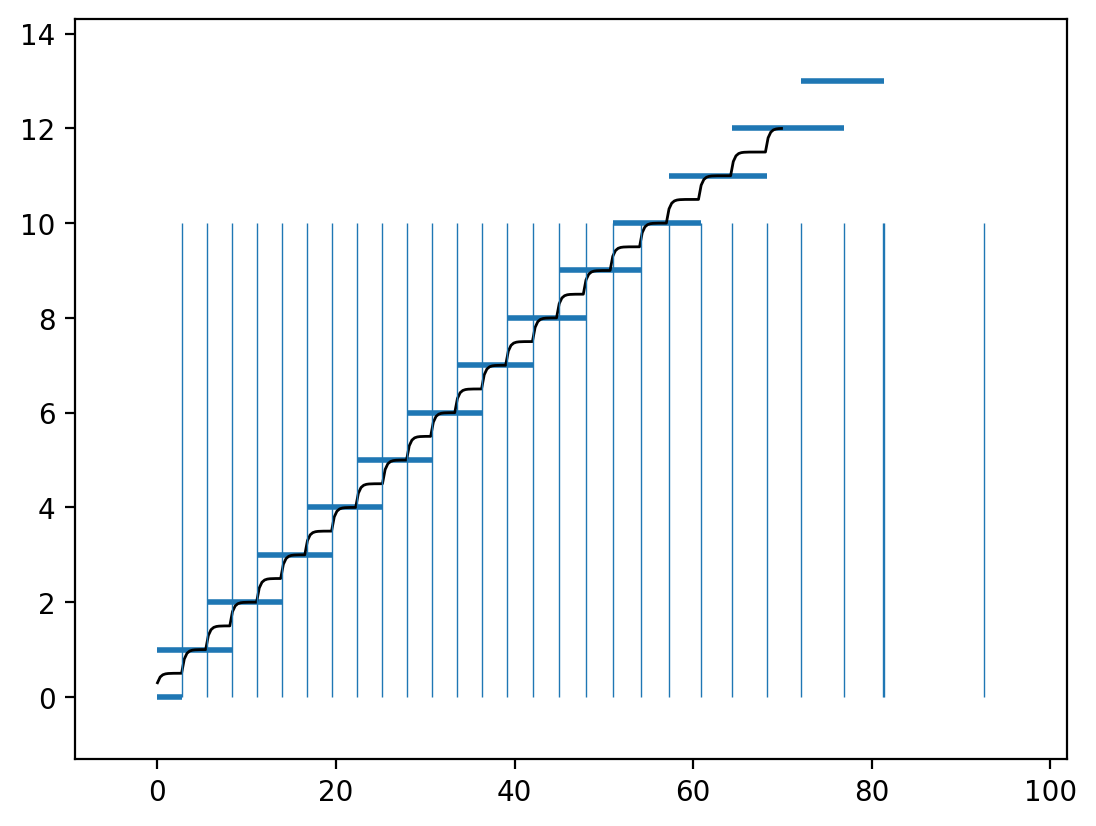

In [3]:
import numpy as np
import math
import pylab as pl
from matplotlib import collections  as mc
import matplotlib.pyplot as plt

ON = [0x70,0x01,0x30,0x28,0x24,0x20,0x1E,0x1D,0x1C,0x1C,0x1C,0x1C,0x1C,0x1C,0x1C]
OFF = [0x70,0x70,0x2C,0x26,0x22,0x1F,0x1E,0x1D,0x1C,0x1C,0x1C,0x1C,0x1C,0x1C,0x1C]

ON=[z*100/1000 for z in ON]
OFF=[z*100/1000 for z in OFF]


t = 0
p = 1
old_p = 0
l = [0]
all_ts = []
for i in range(len(ON)-1,0,-1):
    l.append(t)
    phase = len(l)-1
    t += ON[i]
    all_ts.append(t)
    l[phase-1] = (l[phase-1],t)
    t += OFF[i]
    all_ts.append(t)

t = 0
targets = []
position = 0
times = np.arange(0,70,0.3)
for t in times:
    mag1, mag2 = None, None
    for i in range(len(l)):
        start, end = l[i]
        if start <= t < end:
            mag1 = i
            start, end = l[i+1]
            if start <= t < end:
                mag2 = mag1+1
            break
    if mag1 is not None and mag2 is not None:
        target = (mag1 + mag2)/2
    else:
        assert mag1 is not None and mag2 is None
        target = mag1

    #speed = math.exp(-abs(target-position)-2.2) # no
    speed = abs(target-position)*0.6
    #speed = 100/(abs(target-position)**2) # no

    if position < target:
        position += speed
    elif position > target:
        position -= speed

    targets.append(position)

lines =[]
for i in range(len(l)-1):
    lines.append( [(l[i][0],i),(l[i][1],i)] ) 

plt.rcParams['figure.dpi'] = 200
lc = mc.LineCollection(lines, linewidths=2)
fig, ax = plt.subplots()
ax.add_collection(lc)
#ax.scatter(times, targets, s=0.1, c="black", zorder=2)
ax.plot(times, targets, linewidth=1, c="black", zorder=2)
ax.autoscale()
ax.margins(0.1)
plt.vlines(x=all_ts,ymin=0,ymax=10,linewidths=0.5)

yo
yo


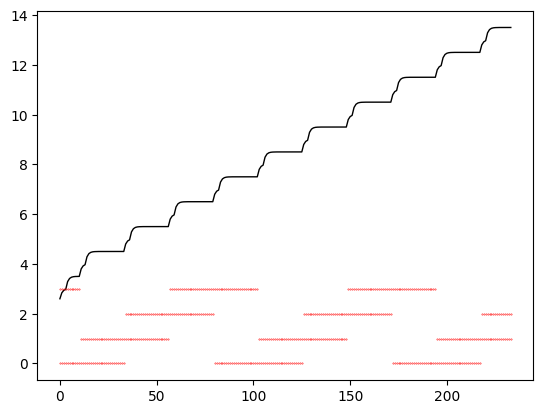

In [41]:
from math import floor
plt.rcParams['figure.dpi'] = 100
def find_target(magnets_on, position):
    wrapped_pos = position % 4

    # This can be 0,1,2,3 oe even 4 !
    close_magnet = round(wrapped_pos)
        
    on_magnet = abs(wrapped_pos - close_magnet) < 0.05
    if on_magnet:
        # Magnets of interest
        # bits are like this: +4,+3,+2,+1,0,-1
        moip = [ 0b0_0011_1, 0b0_0111_0, 0b0_1110_0, 0b1_1100_0, 0b0_0011_1][round(wrapped_pos)]
        position = round(position)
    else:
        close_magnet = floor(wrapped_pos)
        moip = [ 0b000110, 0b001100, 0b011000, 0b110000 ][int(wrapped_pos)]

    # Find the magnets which participate to the movement of the rotor
    mask = (magnets_on << 1)
    if magnets_on & 1 != 0:
        mask |= 0b1_0000_0
    if magnets_on & 0b1000 != 0:
        mask |= 0b0_0000_1

    pulling_magnets= moip & mask

    # From magnet position to "angle"
    targets = []
    for i in range(6):
        if pulling_magnets & (1 << i) != 0:
            targets.append(i-1)

    loop_start = floor(position / 4)*4
    if len(targets) == 1:
        target = targets[0] + loop_start
    elif len(targets) == 2:
        target = (targets[0] + targets[1])/2 + loop_start
    else:
        target = None

    return target


position = 2
times = np.arange(0,70,0.3)
positions = []

mags = [[],[],[],[]]

magnets_on = 0
for i,t in enumerate(times):
    if i == 100:
        print("yo")
        print("yo")

    magnets_on = (3 << (((1001+i)//23)%4)) 
    magnets_on = magnets_on | ((magnets_on & 16) >> 4)
    target = find_target(magnets_on, position)
    
    if target is not None:
        speed = (target-position)*0.6
        position += speed

    positions.append(position)
    for m in range(4):
        if magnets_on & (1 << m) > 0:
            v = m
        else:
            v = -1
        mags[m].append(v)
    
fig, ax = plt.subplots()
r = np.arange(0,len(times))
ax.plot(r, positions, linewidth=1, c="black", zorder=2)
for m in range(4):
    ma = np.array(mags[m])
    
    ax.scatter(r[ma >= 0], ma[ma >= 0], s=0.1, c="red", zorder=2)


In [45]:
# https://fr.wikipedia.org/wiki/%C3%89quation_diff%C3%A9rentielle_lin%C3%A9aire_d%27ordre_un

from math import exp, log
x = 1
t0 = 0
k=0.99
dt=0.1
c = x*exp(-k*t0)
good_x=0.3
print(f"Time to reach given x={good_x}: {(log(c) - log(good_x))/k:.3f}s")
for i, t in enumerate(np.arange(0,dt*15,dt)):
    print(f"{i}: t={i*dt} {x:.5f} {c*exp(-k*t)}")
    x -= x*k*0.1



Time to reach given x=0.3: 1.216s
0: t=0.0 1.00000 1.0
1: t=0.1 0.90100 0.9057427080235485
2: t=0.2 0.81180 0.8203698531378311
3: t=0.30000000000000004 0.73143 0.7430440123619398
4: t=0.4 0.65902 0.6730066959373864
5: t=0.5 0.59378 0.6095709072963093
6: t=0.6000000000000001 0.53499 0.5521144043069306
7: t=0.7000000000000001 0.48203 0.5000735956957676
8: t=0.8 0.43431 0.4529380127765577
9: t=0.9 0.39131 0.410245302259044
10: t=1.0 0.35257 0.3715766910220457
11: t=1.1 0.31767 0.336552878364737
12: t=1.2000000000000002 0.28622 0.3048303154431968
13: t=1.3 0.25788 0.2760978353971936
14: t=1.4000000000000001 0.23235 0.2500736011120941
